In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import os
from torch.optim import Adam
import nibabel as nib
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

In [2]:
# Determine the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device : {device}')

Device : cuda


**Load dataset**

In [3]:
base_path = r'C:\Users\user\Desktop\Brain-Tumor\Train\Brain_Tumor_Classification'

train_path = os.path.join(base_path, 'Training')
testing_path = os.path.join(base_path, 'Testing')

if not (os.path.exists(train_path) and os.path.exists(testing_path)):
    print('Failed to find the data path ')
else:
    print(f'Training path : {train_path}')
    print(f'Testing path : {testing_path}')

Training path : C:\Users\user\Desktop\Brain-Tumor\Train\Brain_Tumor_Classification\Training
Testing path : C:\Users\user\Desktop\Brain-Tumor\Train\Brain_Tumor_Classification\Testing


In [4]:
# Define a Dataset class

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        super().__init__()
        self.root_dir = root_dir
        self.transform = transform
        self.img_paths = []
        self.labels = []

        # Mapping folder names to labels 
        class_folders = sorted(os.listdir(root_dir))
        self.class_to_idx = {class_folder:idx for idx, class_folder in enumerate(class_folders)}

        for class_folder in class_folders:
            folder_path = os.path.join(root_dir,class_folder)
            for img_name in os.listdir(folder_path):
                img_path = os.path.join(folder_path,img_name)
                self.img_paths.append(img_path)
                self.labels.append(self.class_to_idx[class_folder])

    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        
        return image,label

In [5]:
# Define your transform
transform = transforms.Compose([
    # Randomly flip the image horizontally with a 50% chance
    transforms.RandomHorizontalFlip(p=0.5),
    
    # Randomly flip the image vertically with a 50% chance
    transforms.RandomVerticalFlip(p=0.5),
    
    # Randomly rotate the image by ±10 degrees
    transforms.RandomRotation(degrees=10),
    
    # Resize the image to 224x224 pixels
    transforms.Resize((224, 224)),
    
    # Convert the image to a tensor with values in the range [0, 1]
    transforms.ToTensor(),
    
    # Normalize the image with mean and standard deviation
    # Use values based on your dataset, for example, for ImageNet:
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Load the dataset
train_dataset = CustomDataset(root_dir=train_path, transform=transform)
test_dataset = CustomDataset(root_dir=testing_path, transform=transform)



# Calculate lengths for training and validation sets
train_size = int(0.8 * len(train_dataset))
valid_size = len(train_dataset) - train_size

# Split the dataset
train_subset, valid_subset = random_split(train_dataset, [train_size, valid_size])




# Create DataLoaders for each subset
train_loader = DataLoader(train_subset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_subset, batch_size=16, shuffle=False)

# Load the test dataset (remains unchanged)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [6]:
# Test data loader

for image, label in train_loader:
    img = image.to(device)
    label = label.to(device)
    break

print(img.shape)
print(label.shape)

torch.Size([16, 3, 224, 224])
torch.Size([16])


**Define the Model**

In [7]:

# Define the custom model
class MobileNetBT(nn.Module):
    def __init__(self, num_classes=4, dropout_prob=0.2):
        super(MobileNetBT, self).__init__()
        # Load the pre-trained MobileNetV2 model
        mobilenet = models.mobilenet_v2(pretrained=True)
        
        #freeze all layers
        for param in mobilenet.parameters():
            param.requires_grad = False
        
        # Replace the classifier with a custom classifier
        self.features = mobilenet.features
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout_prob),  # Dropout layer with 20% probability
            nn.Linear(mobilenet.last_channel, 512),  # Linear layer with 1000 output features
            nn.ReLU(inplace=True),  # ReLU activation
            nn.Dropout(p=dropout_prob),  # Additional dropout layer
            nn.Linear(512, num_classes)  # Final linear layer with 4 output classes
        )

        # Unfreeze the last 5 layers of MobileNetV2
        self.unfreeze_last_n_layers(mobilenet.features, 5)
        
    def unfreeze_last_n_layers(self, module, n):
        """
        Unfreeze the last `n` layers of a given module.
        """
        # Identify the named modules
        named_modules = list(module.named_children())
        # Iterate over the last `n` layers and unfreeze them
        for i, (name, child) in enumerate(named_modules[-n:]):
            for param in child.parameters():
                param.requires_grad = True
            print(f"Unfreezing layer: {name}")

    def forward(self, x):
        x = self.features(x)
        x = x.mean([2, 3])  # Global average pooling
        x = self.classifier(x)
        return x

In [8]:
# Instantiate the model
model = MobileNetBT(num_classes=4)
model = model.to(device)

Unfreezing layer: 14
Unfreezing layer: 15
Unfreezing layer: 16
Unfreezing layer: 17
Unfreezing layer: 18


c:\Users\user\anaconda3\envs\tf-env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\user\anaconda3\envs\tf-env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
# Calculate the total number of parameters
total_params = sum(p.numel() for p in model.parameters())

print(f'The number of parameters : {total_params}')

The number of parameters : 2881796


In [10]:
# Test the model and input compatability

test = model(img)

print(test.shape)

torch.Size([16, 4])


**Train**

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)
scheduler = lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1)
num_epochs = 15
patience = 8
best_val_acc = 0.0
epochs_no_improve = 0

Epoch [1/15], Training Loss: 0.7199, Validation Accuracy: 0.8571
Best model saved!
Epoch [2/15], Training Loss: 0.4388, Validation Accuracy: 0.9024
Best model saved!
Epoch [3/15], Training Loss: 0.3946, Validation Accuracy: 0.8955
Epoch [4/15], Training Loss: 0.3050, Validation Accuracy: 0.9059
Best model saved!
Epoch [5/15], Training Loss: 0.3053, Validation Accuracy: 0.9286
Best model saved!
Epoch [6/15], Training Loss: 0.3018, Validation Accuracy: 0.9199
Epoch [7/15], Training Loss: 0.3109, Validation Accuracy: 0.9251
Epoch [8/15], Training Loss: 0.2608, Validation Accuracy: 0.8711
Epoch [9/15], Training Loss: 0.1915, Validation Accuracy: 0.9477
Best model saved!
Epoch [10/15], Training Loss: 0.1672, Validation Accuracy: 0.9355
Epoch [11/15], Training Loss: 0.1385, Validation Accuracy: 0.9530
Best model saved!
Epoch [12/15], Training Loss: 0.1312, Validation Accuracy: 0.9512
Epoch [13/15], Training Loss: 0.1294, Validation Accuracy: 0.9495
Epoch [14/15], Training Loss: 0.1120, Valid

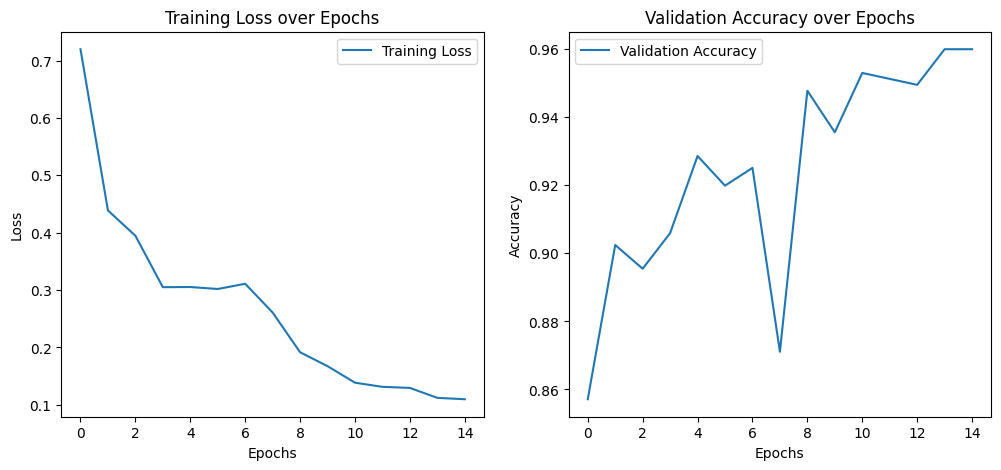

In [12]:
# Track loss and accuracy
train_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    # Calculate average training loss
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)  
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = val_correct / val_total
    val_accuracies.append(val_acc)
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

    # Check if validation accuracy improved
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
        # Save the best model
        torch.save(model.state_dict(), f'BTC_at_{best_val_acc:.4f}.pth')
        print('Best model saved!')
    else:
        epochs_no_improve += 1

    # Adjust learning rate
    scheduler.step()

    # Check for early stopping
    if epochs_no_improve >= patience:
        print('Early stopping!')
        break

# Plot training loss and validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(len(val_accuracies)), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.legend()

plt.show()